# BitBIRCH best practices

This is a tutorial notebook that showcases a simple workflow of BitBIRCH clustering,
incluiding threshold selection, and the refinement of singletons.

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- *BitBIRCH-Lean* `TO-BE-ADDED`

Please reach out to one of the following with any questions or concerns. 

- Ramon Alain Miranda Quintana: `quintana At chem.ufl.edu`
- Kenneth Lopez Perez: `klopezperez At chem.ufl.edu`
- Ignacio Pickering: `ipickering At chem.ufl.edu`
- Krisztina Zsigmond: `kzsigmond At ufl.edu`
- Miroslav Lzicar: `miroslav.lzicar At deepmedchem.com`

## Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do
this, run the following commands in your terminal:

```
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .
```

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis
import bblean.similarity as iSIM
import numpy as np
import matplotlib.pyplot as plt

Now let's take some SMILES strings and compute molecular fingerprints:

In [2]:
smiles = bblean.load_smiles("./chembl-33-natural-products-subset.smi", max_num=10000)

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="ecfp4")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (10000, 256), DType: uint8

The most efficient way to store and manipulate fingerprints is using *packed*
fingerprint arrays. Packed arrays save the features in a compressed representation. To
convert between packed and unpacked fingerprints you can use
`bblean.pack_fingerprints(fps)` and `bblean.unpack_fingerprints(fps)`.

In [3]:
fps_unpacked = bblean.unpack_fingerprints(fps)
print(f"Shape unpacked: {fps_unpacked.shape}, DType unpacked: {fps_unpacked.dtype}")

fps = bblean.pack_fingerprints(fps_unpacked)
print(f"Shape re-packed: {fps.shape}, DType re-packed: {fps.dtype}")

Shape unpacked: (10000, 2048), DType unpacked: uint8

Shape re-packed: (10000, 256), DType re-packed: uint8

## Clustering fingerprints

First to define an optimal threshold we will take a look into the average similarity of
the fingerprints we want to cluster. For this we will use the iSIM formalism which can
calculate the average similarity with linear complexity.

In [4]:
average_sim = iSIM.jt_isim_unpacked(fps_unpacked)
print(f"Average similarity: {average_sim:.4f}")

Average similarity: 0.1312

Now, we will estimate the standard deviation of the similarities using a stratified
sample from our data set.

In [7]:
# Take a representative sample to estimate similarity std
representative_samples = iSIM.jt_stratified_sampling(fps, n_samples=50)

# Calculate similarity matrix for the representative samples and exclude self-similarities
sim_matrix = iSIM.jt_sim_matrix_packed(fps[representative_samples])
sim_matrix = sim_matrix[~np.eye(sim_matrix.shape[0], dtype=bool)]

# Obtain mean and standard deviation
_, std = np.mean(sim_matrix), np.std(sim_matrix)
print(f"Estimated similarity mean: {average_sim:.4f}, std: {std:.4f}")

Estimated similarity mean: 0.1312, std: 0.0580

Now, we will do the initial clustering. We recommend using a threshold of the average plus 4 standard deviations.

In [8]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
optimal_threshold = average_sim + 4 * std
bb_tree = bblean.BitBirch(branching_factor=50, threshold=optimal_threshold, merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed
# fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.3631015470344815, branching_factor=50, merge_criterion='diameter')

Lets analyze the results to check the number of singletons

In [12]:
clusters = bb_tree.get_cluster_mol_ids()
print("Number of singletons", sum(1 for c in clusters if len(c) == 1))

Number of singletons 944

As we see, the number of singletons is quite high. To solve this we will recluster
the tree. We will do this increasing the threshold by
one standard deviation each iteration. Usually 5 iterations is enough to get rid of spurious singletons that are not really outliers.

For this example we see a reduction of almost one third of the
singletons, depending on your application, you may want to change the `extra_threshold` parameter, and the number of iterations.

In [13]:
bb_tree.recluster_inplace(iterations=5, extra_threshold=std, shuffle=False, verbose=True)

Current number of clusters: 1971
Current number of singletons: 944
Current number of clusters: 1746
Current number of singletons: 785
Current number of clusters: 1679
Current number of singletons: 729
Current number of clusters: 1658
Current number of singletons: 704
Current number of clusters: 1656
Current number of singletons: 702
Final number of clusters: 1652
Final number of singletons: 697


BitBirch(threshold=0.6530114120345158, branching_factor=50, merge_criterion='diameter')

We see that the number of singletons significantly decreased

## Further analysis and Visualization

Lets inspect some features of the generated clusters:

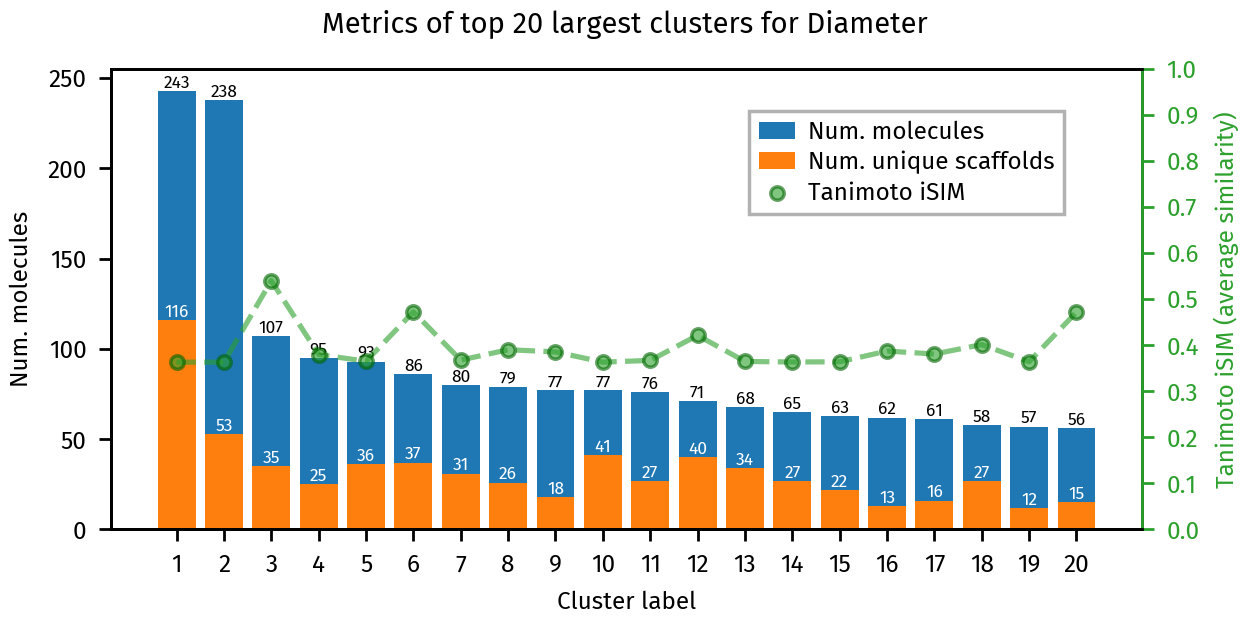

In [14]:
# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, fps, smiles)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
plt.show()

In [15]:
# Total clusters
print("Number of clusters: ", len(clusters))

# Clusters with more than 10 molecules
large_clusters = [c for c in clusters if len(c) > 10]
print("Number of clusters with more than 10 molecules: ", len(large_clusters))

Number of clusters:  1652

Number of clusters with more than 10 molecules:  227

We can visually inspect an individual cluster by calling
`plotting.dump_mol_images`. By default this generates multiple images with 30
molecules each.

In [16]:
plotting.dump_mol_images(smiles, clusters, cluster_idx=0)

We can also visualize the clusters using a t-SNE plot with `plotting.tsne_plot`:

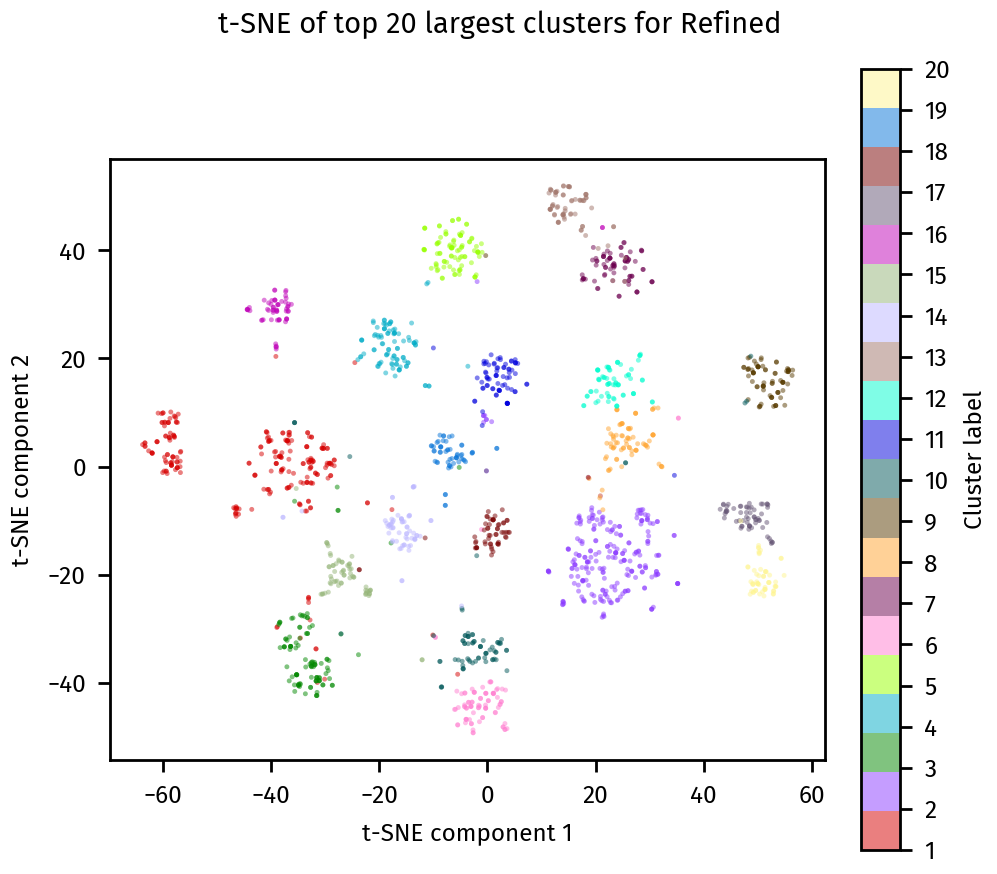

In [17]:
plotting.tsne_plot(ca, title="Refined")
plt.show()

## Final cluster assignments

Once we are happy with the clustering results, we can save the final cluster
assignments. to a `*.csv` file.

In [8]:
bb_tree.dump_assignments("smiles-assignments.csv", smiles)